In [38]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib as mpl
from  IPython.display import clear_output

from aruco_lib import get_img, detect_aruco_markers

## Control image

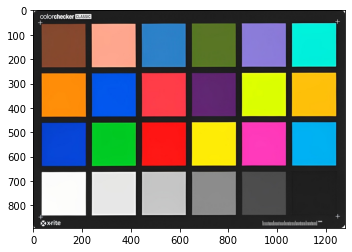

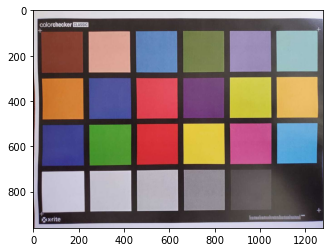

In [39]:
control_img = cv2.imread('original.jpg')
objective_img = cv2.imread('original_print.jpg')

control_img = cv2.cvtColor(control_img, cv2.COLOR_BGR2RGB)
objective_img = cv2.cvtColor(objective_img, cv2.COLOR_BGR2RGB)

plt.imshow(control_img)
plt.show()
plt.imshow(objective_img)
plt.show()

## Objective image with aruno markers

In [40]:
#Generar los 4 aruno markers
"""
aruco_type = "DICT_4X4_50"
id = 4 
img  = get_img(aruco_type, id)
cv2.imwrite("ID_"+str(id)+"_"+aruco_type+".png", img)
"""

'\naruco_type = "DICT_4X4_50"\nid = 4 \nimg  = get_img(aruco_type, id)\ncv2.imwrite("ID_"+str(id)+"_"+aruco_type+".png", img)\n'

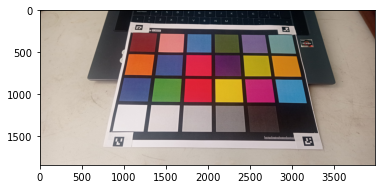

[Inference] ArUco marker ID: 3
Center -> x:934 y:1562
[Inference] ArUco marker ID: 4
Center -> x:3189 y:1556
[Inference] ArUco marker ID: 2
Center -> x:2922 y:229
[Inference] ArUco marker ID: 1
Center -> x:1177 y:206


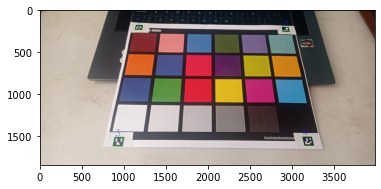

In [41]:
aruco_type = "DICT_4X4_50"

name_img = "test_01.jpg"
img  = cv2.imread(name_img)
img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
img_detected, centers = detect_aruco_markers(img, aruco_type)
plt.imshow(img_detected)
plt.show()

## Change Perspective

In [42]:
def order_points(pts):
	rect = np.zeros((4, 2), dtype = "float32")
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	return rect

In [43]:
def order_points_new(pts):
    xSorted = pts[np.argsort(pts[:, 0]), :]
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost
    rightMost = rightMost[np.argsort(rightMost[:, 1]), :]
    (tr, br) = rightMost
    return np.array([tl, tr, br, bl], dtype="float32")

In [44]:
def four_point_transform(image, pts):
	rect = order_points_new(pts)
	(tl, tr, br, bl) = rect

	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")

	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

	return warped, rect

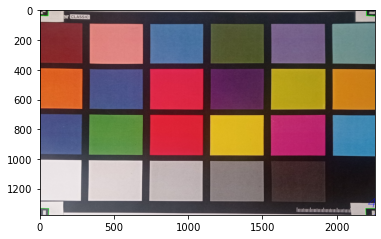

In [45]:
img_detected, rect  = four_point_transform(img_detected, centers.copy())
plt.imshow(img_detected)

0


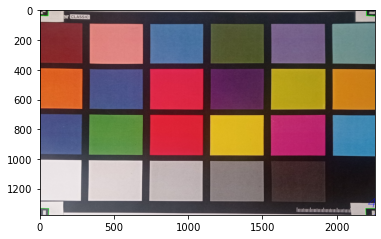

In [46]:
pos = 0

for i in range(len(rect)):
    if rect[i][1] == centers[0][1]  and rect[i][0] == centers[0][0]:
        pos = i
        break

rows, cols, ch = img_detected.shape
print(pos)
if pos ==1:
    transform_matrix = cv2.getRotationMatrix2D((cols/2,rows/2),90,1) #(rotation center, degrees, scale)
    img_detected = cv2.warpAffine(img_detected,transform_matrix,(cols,rows)) # (image, transform matrix, image size)
elif pos ==2:
    transform_matrix = cv2.getRotationMatrix2D((cols/2,rows/2),180,1) #(rotation center, degrees, scale)
    img_detected = cv2.warpAffine(img_detected,transform_matrix,(cols,rows)) # (image, transform matrix, image size)
elif pos ==3:
    transform_matrix = cv2.getRotationMatrix2D((cols/2,rows/2),-90,1) #(rotation center, degrees, scale)
    img_detected = cv2.warpAffine(img_detected,transform_matrix,(cols,rows)) # (image, transform matrix, image size)

plt.imshow(img_detected)

In [47]:
def get_points_from_colors(img, ini_x, div_x, div_y, margin, show_points = False, mark_size = 5):
    n,m,c  = img.shape

    x = np.zeros((24),dtype = "int")
    y = np.zeros((24),dtype = "int")

    index = 0
    for idx, j in enumerate(range(ini_x, m+1, m//div_x)):
        for idx2, i in enumerate(range(0, n,n//div_y)): 
            if idx2>0 and idx2<div_y and len(x)<=24:
                u = j
                if idx == div_x:
                    u = j - (m/margin)
                elif idx == 0:
                    u = j + (m/margin)
                x[index] = u
                y[index] = i
                index+=1
    if  show_points : 
        plt.imshow(img)
        plt.plot(x, y, marker="o", markersize=mark_size, markeredgecolor="black", markerfacecolor="white")
        plt.show()

    points = np.zeros((24,2), dtype = "int")
    points[:,0] = x[:]
    points[:,1] = y[:]
    return points


In [48]:
def get_colors_from_points(points, img, windows_size = 10, show_colors = False):
    matrix = np.zeros((24,3))
    for i in range(len(points)):
        for u in range(points[i][1],points[i][1]+windows_size):
            for v in range(points[i][0],points[i][0]+windows_size):
                matrix[i]+=img[u][v]
        matrix[i]/=float(windows_size*windows_size)
        if show_colors: 
            color = np.zeros((300, 300, 3), dtype=np.uint8)
            color[:,:,0] = matrix[i][0]
            color[:,:,1] = matrix[i][1]
            color[:,:,2] = matrix[i][2]
            plt.imshow(color.astype("uint8"))
            plt.show()
    return matrix.astype("int")

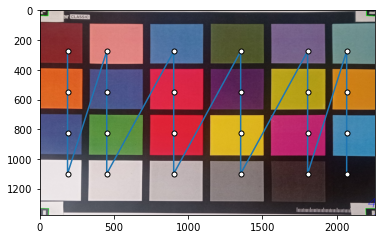

In [49]:
points = get_points_from_colors(img_detected,0,5,5,12, True)
Mo = get_colors_from_points(points,img_detected)

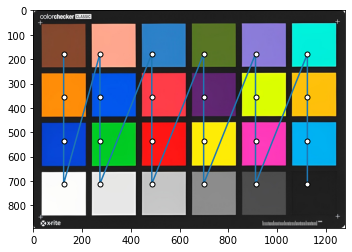

In [50]:
points = get_points_from_colors(control_img,60,6,5,20, True)
Control = get_colors_from_points(points,control_img)

## Optimization 

In [51]:
def f(P):
    global Control
    global Mo

    m = np.reshape(P.copy(),(3,3))
    Mc = np.matmul(Mo,m)
   
    penalizacion = 0
    
    """
    aux = np.zeros(Mc.shape)
    aux = np.where(Mc > 255, 255, 0)
    aux = np.where(Mc<0, 255, 0)
    aux = np.absolute(aux)
    penalizacion+=np.sum(aux)
    """
    
    Mc = np.where(Mc > 255, 255, Mc)
    Mc = np.where(Mc < 0 , 0, Mc)

    for i in range(3):
        if 1 - (np.sum(m[i,:])) > 1e-5: penalizacion = 9999999999
    
    return np.sum(np.abs(Mc-Control)) + penalizacion


In [52]:
Kr = (np.sum(Control[:,0])/24)/(np.sum(Mo[:,0])/24)
Kg = (np.sum(Control[:,1])/24)/(np.sum(Mo[:,1])/24)
Kb = (np.sum(Control[:,2])/24)/(np.sum(Mo[:,2])/24)

bounds = [[1,10], [-10,1], [-10,1],
        [-10,1],   [1,10], [-10,1],
        [-10,1],   [-10,1],  [1,10]
        ] 

In [53]:
def color_correction(img, ccm):
    img2 = img.reshape((img.shape[0] * img.shape[1], 3))
    output = np.matmul(img2, ccm)  
    output = np.where(output > 255, 255, output)
    output = np.where(output < 0 , 0, output)
    return output.reshape(img.shape).astype(img.dtype)

In [54]:
val = 0
def plot(P):
    global val 
    global img 
    clear_output(wait=True)

    Paux = np.reshape(P.copy(),(3,3))
    print(val)
    val+=1

    res = color_correction(img, Paux)
    print(P)
    print(f(P))
    plt.imshow(res)
    plt.show()
    res = cv2.cvtColor(res,cv2.COLOR_BGR2RGB)
    cv2.imwrite("output_"+name_img, res)

In [55]:
#from scipy.optimize import differential_evolution
#res = differential_evolution(f, bounds,tol=-1000,maxiter=500,popsize=250)
#print(res)

0
[ 1.56290357  0.0140479  -0.35805854 -0.21341793  1.5714864  -0.35610951
 -0.35638723 -0.33268466  2.15158396]
1211.1032208140487


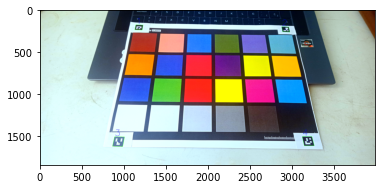

rep:  1 / 1
(array([ 1.56290357,  0.0140479 , -0.35805854, -0.21341793,  1.5714864 ,
       -0.35610951, -0.35638723, -0.33268466,  2.15158396]), 500, 1211.1032208140487, 125250)


In [56]:
from differential_evolution import differential_evolution
res =  differential_evolution(f, plot, 500 , bounds, popsize=250,Cr=0.75, rep=1)
print(res)